## Logistic Regression

logistic regression model trainable with SGD using numpy


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

from sklearn.datasets import load_digits
import numpy as np

digits = load_digits()

###### First let's define a helper function to compute the one hot encoding of an integer array for a fixed number of classes:

In [4]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [5]:
one_hot(10, 3)

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

In [6]:
one_hot(10, [3,2,1,0])

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [7]:
one_hot(10, [0, 4, 9, 1])

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

Let's take a moment to take a look at the dataset before we start using it.

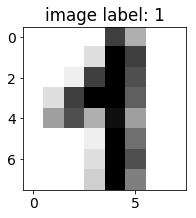

In [8]:
sample_index = 42 # change this to see different examples
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

- normalization (for more take a look at http://scikit-learn.org/stable/modules/preprocessing.html)
- train/test split

In [9]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_train = one_hot(10, y_train)
Y_test = one_hot(10, y_test)

In [10]:
Y_train = one_hot(10, y_train)
Y_train[:3]

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

Let's display the one of the transformed samples (after feature standardization):

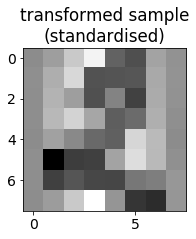

In [11]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(X_train[sample_index].reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("transformed sample\n(standardised)");

The scaler object makes it possible to recover the original sample:

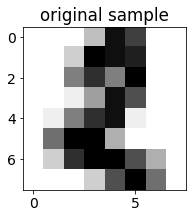

In [12]:
plt.figure(figsize=(3, 3))
plt.imshow(scaler.inverse_transform(X_train[sample_index]).reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("original sample");

Now let's implement the softmax vector function:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

In [13]:
def softmax(X):
    return (np.exp(X)/np.sum(np.exp(X), axis=0))

Make sure that this works one vector at a time (and check that the components sum to one):

In [14]:
print(np.sum(softmax([10, 8, -3])))

1.0


Note that a naive implementation of softmax might not be able process a batch of activations in a single call (but we need that):

In [15]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(np.sum(softmax(X[0])))
softmax(X)

1.0


array([[  9.99983299e-01,   4.74258732e-02,   9.99999959e-01],
       [  1.67014218e-05,   9.52574127e-01,   4.13993755e-08]])

Implement a function that given the true one-hot encoded class `Y_true` and and some predicted probabilities `Y_pred` returns the negative log likelihood. For this problem we are using the "log loss" loss function (also known as cross-entropy).

This `nll` is a scalar computed using all samples in our training set. The likelihood measures how likely something is. Using the term "likelihood" instead of probability because the likelihood does not have to be a probability.

$$L = P_1 \cdot P_2 \cdot P_3 \cdot ... $$

However multiplying lots of small numbers together is a numerical disaster. Use $\log(ab) = \log(a) + log(b)$ to convert the product into a sum (hence the name log-likelihood). The negative just means we multiply everything by minus one.

In [18]:
EPSILON = 1e-8 # this is here to give you a hint on how to deal with the case when y_pred=0
#L y, f (x)  = log 1 + exp(−yf (x) 
def nll_(Y_true, Y_pred):
    return np.sum((np.log(1 + np.exp(-Y_pred*Y_true))))

# Make sure that it works for a simple sample at a time
print(nll_(np.array([1, 0, 0]), np.array([.99, 0.01, 0])))

1.70225530858


Check that the `nll` of a very confident yet incorrect prediction is a much higher positive number:

In [19]:
print(nll_(np.array([1, 0, 0]), np.array([0.01, 0.01, .98])))

2.07445404163


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be passed in as 2D arrays:

In [20]:
def nll(Y_true, Y_pred):
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred)
    loglikelihoods = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis=1)
    return -np.mean(loglikelihoods)

In [21]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.0033501019175


All the ingredients for training a logistic regression model using gradient descent are in place.

Studying **one sample at a time**.

In [22]:
class LogisticRegression():
    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        self.output_size = output_size
        
    def forward(self, X):
        # y=softmax(Wx+b)      
        return softmax(np.dot(X, self.W) + self.b)

    def predict(self, X):
        # for each sample in X return the predicted class
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
    
    def grad_loss(self, x, y_true):
        # compute gradient with respect to W and b for a sample x
        # and the true label y_true
        # ddW−log(softmax(Wx+b))
        y_pred = self.forward(x)
        
        dnll_output =  y_pred - one_hot(self.output_size, y_true)
        
        grad_W = np.outer(x, dnll_output)
        grad_b = dnll_output
    
        grads = {"W": grad_W, "b": grad_b}
        return grads
    
    def train(self, x, y, learning_rate):
        # compute one step of traditional gradient descent update without momentum
        # and update W and b
        grads = self.grad_loss(x, y)
        
        self.W = self.W - (learning_rate * grads['W'])
        self.b = self.b - (learning_rate * grads['b'])
        
    def loss(self, x, y):
        # use 'nll' to compute the loss for the sample x with true label y
        return nll(one_hot(self.output_size, y), self.forward(x))

    def accuracy(self, X, y):
        # compute accuracy for samples X with true labels y
        y_preds = np.argmax(self.forward(X), axis=1)

        return np.mean(y_preds == y)

In [23]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = Y_train.shape[1]
lr = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_train, y_train)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (train_loss, train_acc, test_acc))
# Question: do you think the accuracy makes sense?

Evaluation of the untrained model:
train loss: 7.4125, train acc: 0.140, test acc: 0.140


5


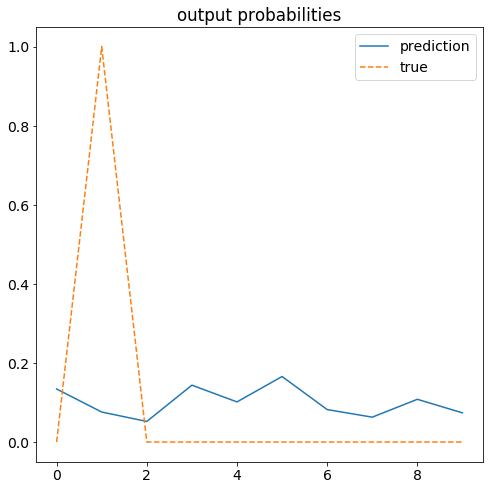

In [24]:
# Test the untrained model on an example
sample_idx = 3
plt.plot(lr.forward(X_train[sample_idx]), linestyle='-', label='prediction')
plt.plot(one_hot(10, y_train[sample_idx]), linestyle='--', label='true')
plt.title('output probabilities')
plt.legend()
print(lr.predict(X_train[sample_idx]))

In [25]:
# Training for one epoch
learning_rate = 0.01

for i, (x, y) in enumerate(zip(X_train, y_train)):
    lr.train(x, y, learning_rate)
    if i % 100 == 0:
        train_loss = lr.loss(X_train, y_train)
        train_acc = lr.accuracy(X_train, y_train)
        test_acc = lr.accuracy(X_test, y_test)
        print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
              % (i, train_loss, train_acc, test_acc))

Update #0, train loss: 7.3815, train acc: 0.151, test acc: 0.152
Update #100, train loss: 6.3857, train acc: 0.769, test acc: 0.781
Update #200, train loss: 6.0044, train acc: 0.879, test acc: 0.885
Update #300, train loss: 5.8690, train acc: 0.889, test acc: 0.911
Update #400, train loss: 5.8769, train acc: 0.898, test acc: 0.922
Update #500, train loss: 5.8250, train acc: 0.901, test acc: 0.941
Update #600, train loss: 6.6902, train acc: 0.828, test acc: 0.933
Update #700, train loss: 6.7002, train acc: 0.832, test acc: 0.926
Update #800, train loss: 6.6916, train acc: 0.830, test acc: 0.919
Update #900, train loss: 6.6623, train acc: 0.832, test acc: 0.919
Update #1000, train loss: 7.4085, train acc: 0.761, test acc: 0.922
Update #1100, train loss: 7.0879, train acc: 0.768, test acc: 0.930
Update #1200, train loss: 7.2283, train acc: 0.733, test acc: 0.933
Update #1300, train loss: 7.2402, train acc: 0.731, test acc: 0.911
Update #1400, train loss: 7.3428, train acc: 0.730, test acc

2


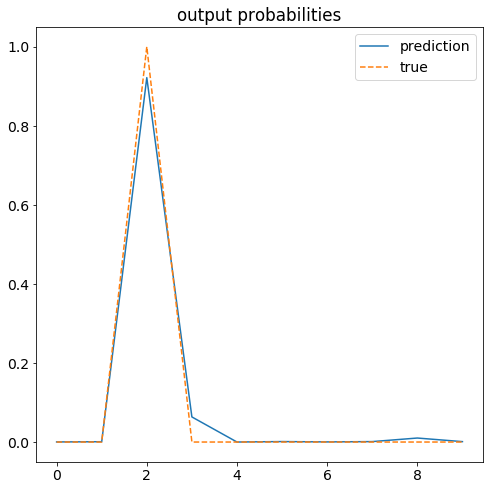

In [26]:
# Evaluate the trained model on an example
sample_idx = 899
plt.plot(lr.forward(X_train[sample_idx]), linestyle='-', label='prediction')
plt.plot(one_hot(10, y_train[sample_idx]), linestyle='--', label='true')
plt.title('output probabilities')
plt.legend()
print(lr.predict(X_train[sample_idx]))

Questions:

* can you find examples that are mispredicted, is there a pattern to the wrong predictions?
* visualise these samples and their predicted classes
* plot the [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to find classes that are hard to separate (maybe eight vs nine?)
* do things improve with training for more epochs?
* experiment with different values of the learning rate. Can you accelerate learning? What happens for very large values of the learning rate? Very small ones?
* convert the training setup to use stochastic gradient descent, does this change things?
* what is the optimal number of epochs to train for? Why?